In [270]:
import numpy as np
from matplotlib import pyplot as plt

from qutrit_rpe import *

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
ux01 = modelX01(0,0)
uz01 = modelZ01()
ux12 = modelX12(0,0)
uz12 = modelZ12()
uy01 = matrix_power(uz01, 3)@ux01@uz01
uy12 = matrix_power(uz12, 3)@ux12@uz12

In [272]:
np.round(uy12@uy01@uy01@np.array([1, 0, 0]),3)

array([0.   -0.j, 0.707-0.j, 0.707-0.j])

In [273]:
xgate = modelX01(0,0.1)
np.round(xgate, 3)

array([[ 0.706-0.035j, -0.035-0.706j,  0.   +0.j   ],
       [-0.035-0.706j,  0.706-0.035j,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.995+0.1j  ]])

In [274]:
np.round(np.log(xgate@uz01@uz01@xgate@uz01@uz01), 3)

/tmp/ipykernel_13505/1697648229.py:1: RuntimeWarning: divide by zero encountered in log
  np.round(np.log(xgate@uz01@uz01@xgate@uz01@uz01), 3)


array([[ -0.   -0.1j  , -36.625-1.107j,    -inf+0.j   ],
       [-37.083+2.356j,  -0.   -0.1j  ,    -inf+0.j   ],
       [   -inf+0.j   ,    -inf+0.j   ,  -0.   +0.2j  ]])

In [275]:
uz01@uz12@uz12@uz01@uz12@uz12

array([[-1.+1.2246468e-16j,  0.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  1.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  0.+0.0000000e+00j,  1.+2.4492936e-16j]])

In [276]:
Gamma_01 = np.diag([1, 1, -2])
Gamma_12 = np.diag([-2, 1, 1])

In [277]:
uz01@uz01@Gamma_01@uz01@uz01

array([[ 1.-2.4492936e-16j,  0.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  1.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  0.+0.0000000e+00j, -2.+0.0000000e+00j]])

In [278]:
#xvec = random_error_vector(0.01, 0.01)
qids = ['Q0', 'Q1']
depol_rates = [0.00, 0.0] # 1 and 2 qubit depolarizing rates

In [292]:
xvec = np.array([0.4, .15, 0, .1] +[0.012, .15, 0.3, .1] + [0]*8)

In [293]:
parse_error_vector(xvec, qids)

{'single_qutrit': {'Q0': {'X01': 0.4,
   'phase01': 0.15,
   'X12': 0.0,
   'phase12': 0.1},
  'Q1': {'X01': 0.012, 'phase01': 0.15, 'X12': 0.3, 'phase12': 0.1}},
 'two_qutrit': {'phi1': 0.0,
  'phi2': 0.0,
  'phi3': 0.0,
  'phi4': 0.0,
  'phi5': 0.0,
  'phi6': 0.0,
  'phi7': 0.0,
  'phi8': 0.0}}

In [294]:
target_model = make_two_qutrit_model(np.zeros(16), single_qutrit_depol=0.0, two_qutrit_depol=0.0, qids=qids)
noise_model = make_two_qutrit_model(xvec, single_qutrit_depol=depol_rates[0], two_qutrit_depol=depol_rates[1], qids=qids)

In [295]:
depths = [2**i for i in range(10)]
edesign = RPEDesign1QT(depths, qids[1], qids)
len(edesign.circ_list)

78

In [296]:
qid = 'Q0'
prep = gY01(qid) + gY12(qid) 
meas = gY01_inv(qid) + gY12_inv(qid)
circ = make_rpe_circuit(gX12(qid), prep, meas, 1, qids)

In [297]:
ds_model = pygsti.data.simulate_data(noise_model, edesign.circ_list, num_samples=1000)
ds_target = pygsti.data.simulate_data(target_model, edesign.circ_list, num_samples=1000)

In [298]:
germ_quadrature_labels_Q0 = {
    'X01 overrot': {
        '+': ['00'],
        '-': ['01']
    },
    'Phase01' : {
        '+' : ['00'], 
        '-' : ['02']
    },
    'X12 overrot': {
        '+': ['01'],
        '-': ['02']
    },
    'Phase12' : {
        '+' : ['00'], 
        '-' : ['01']
    }
}

In [299]:
estimator = RPEEstimator1QT(ds_model, edesign, germ_quadrature_labels_Q0)

In [300]:
2*np.pi

6.283185307179586

In [301]:
estimator.param_estimates

{'Phase01': 0.149952191007691,
 'Phase12': 0.10001227232120292,
 'X01 overrot': 0.012094776210896718,
 'X12 overrot': 0.3005137196867631}

In [289]:
estimator.trig_last_good_gens

{'Phase01': 9, 'Phase12': 9, 'X01 overrot': 9, 'X12 overrot': 9}

In [290]:
edesign.make_phase01_cos_circuits([0, 1, 2], 'Q0', qids)

[Circuit(Gx01:Q0Gx01:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gx01:Q0Gz12:Q0Gz12:Q0@(Q0,Q1)),
 Circuit(Gx01:Q0Gx01:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gx01:Q0Gz12:Q0Gz12:Q0@(Q0,Q1)),
 Circuit(Gx01:Q0Gx01:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gz01:Q0Gz01:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gx12:Q0Gz12:Q0Gz12:Q0Gz12:Q0Gz01:Q0Gz01:Q0Gx01:Q0Gx01:Q0Gz12:Q0Gz12:Q0@(Q0,Q1))]

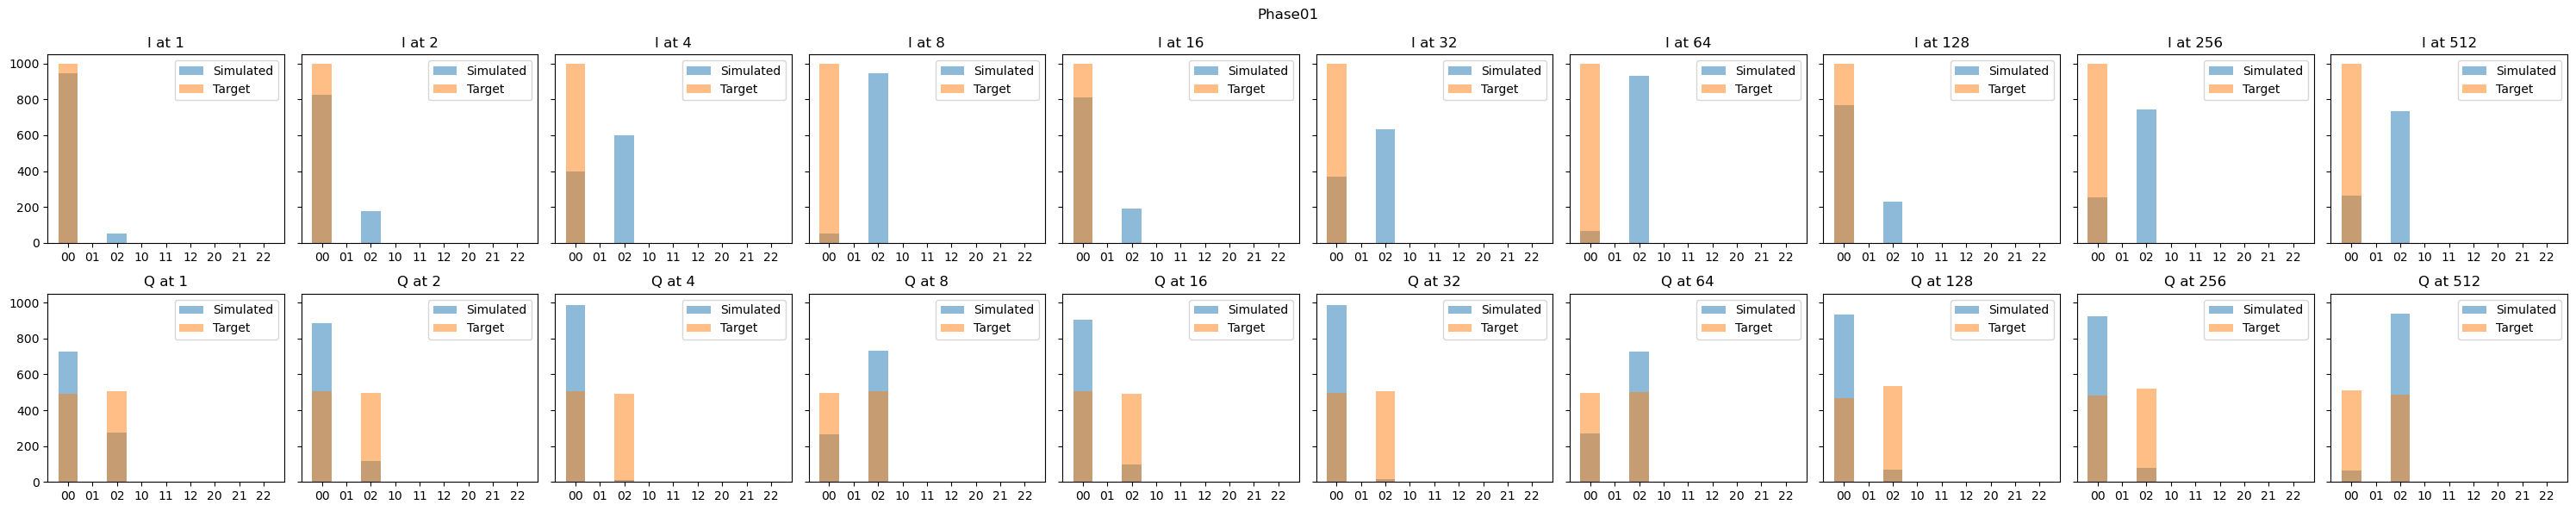

<Figure size 640x480 with 0 Axes>

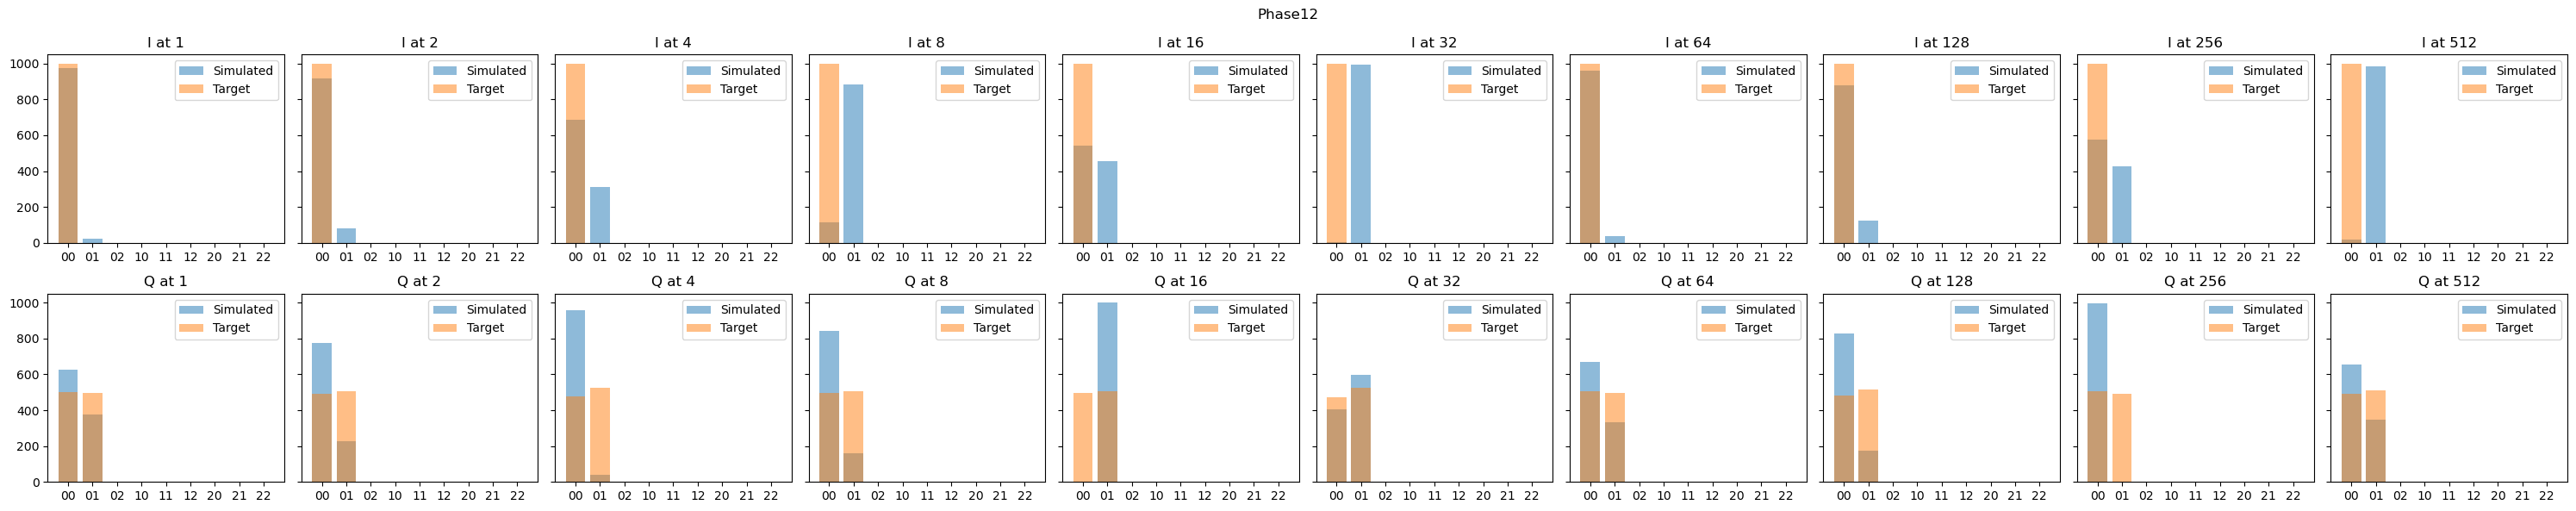

<Figure size 640x480 with 0 Axes>

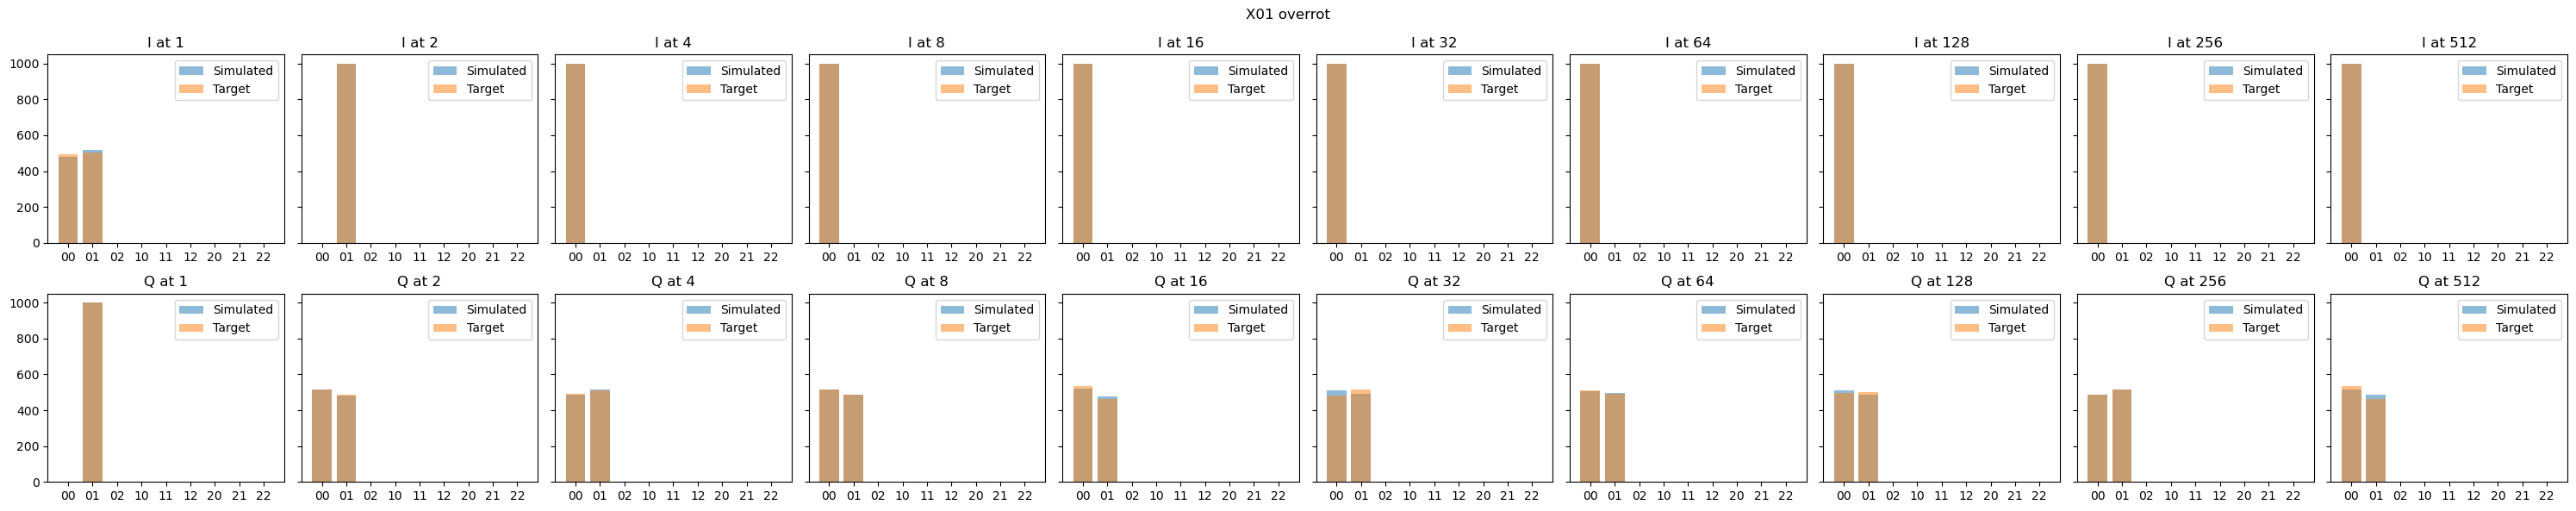

<Figure size 640x480 with 0 Axes>

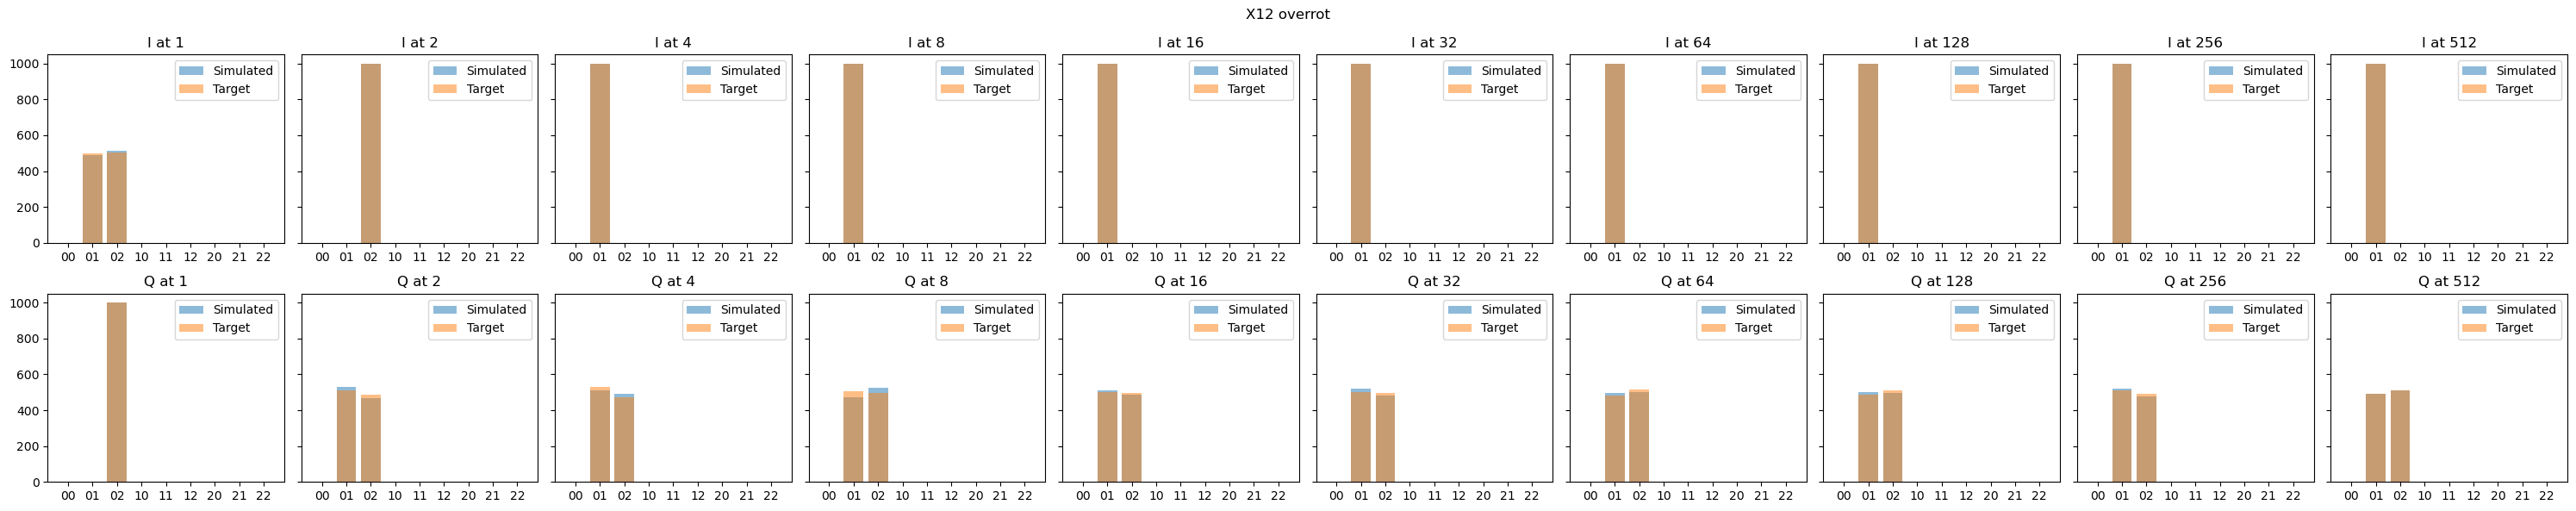

<Figure size 640x480 with 0 Axes>

In [291]:
estimator.plot_all_outcomes(ds_target)